In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
training_data = pd.read_parquet('C:/Users/nguye/Downloads/BTCUSDT/')
labels = pd.read_parquet('C:/Users/nguye/Downloads/LABEL_BTCUSDT/')
labels.drop(columns="SYMBOL", inplace=True)
join_data = training_data.join(labels, how='left')
training_data.index = pd.to_datetime(training_data.index, unit='ms')
labels.index = pd.to_datetime(labels.index, unit='ms')


In [2]:
full_data = training_data.join(labels, how='left')
# labeled_data = training_data.join(labels, how='right')
labeled_data = training_data.join(labels)
labeled_data.dropna(inplace=True)

In [5]:
full_data

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,YEAR_AND_MONTH,LABEL
OPEN_TIME,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,9.333621e+03,9,0.489061,2.089105e+03,201708,NaN
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,201708,NaN
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,201708,NaN
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,2.065448e+03,9,0.085455,3.642181e+02,201708,NaN
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570,9.931161e+03,11,1.546491,6.595688e+03,201708,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 10:40:00,26398.05,26400.00,26390.00,26398.00,53.635990,1.415872e+06,1450,23.608760,6.232054e+05,202306,NaN
2023-06-19 10:45:00,26398.00,26399.97,26396.01,26396.89,42.078480,1.110761e+06,1245,20.234130,5.341305e+05,202306,NaN
2023-06-19 10:50:00,26396.90,26396.90,26383.05,26392.77,86.849990,2.292146e+06,1605,29.394780,7.757901e+05,202306,NaN


In [4]:
labeled_data.shape

(47662, 11)

<Axes: >

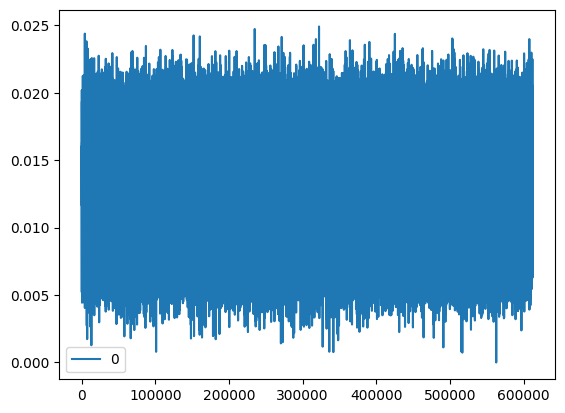

In [3]:
mu = -1.4 
sigma = 0.01
dt = 0.1
x_bm = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(-2, np.sqrt(dt), size=(1, full_data.shape[0])).T)
min_bm = x_bm.min()
x_bm = np.abs(x_bm - min_bm) 
sns.lineplot(data=x_bm)

## Calculate R and V of data

29 [[1.         0.08964284]
 [0.08964284 1.        ]]


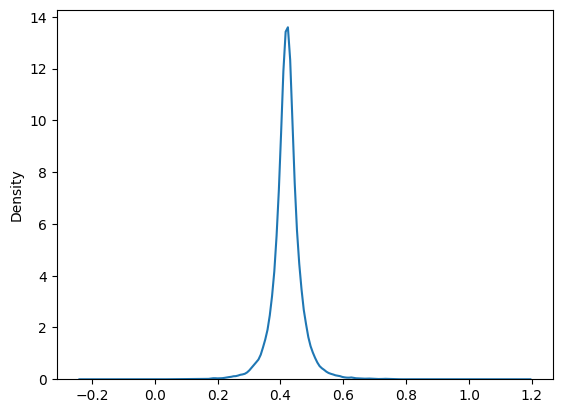

In [4]:
# full_data['RETURN_RATE'] = (
#     full_data['CLOSE'] - full_data['OPEN']) / full_data['OPEN']
for i in range(29, 30):
    full_data['RETURN_RATE'] = full_data['CLOSE'].shift(
        -i)/full_data['CLOSE'] - 1
    x = full_data['CLOSE'].shift(-i)/full_data['CLOSE'] - 1
    std_backward = full_data['CLOSE'].rolling(i).std()
    # rooling backward
    std_forward = full_data['CLOSE'].rolling(i).std().shift(-i)
    std_ratio = std_forward / std_backward

    full_data['V'] = std_ratio
    full_data['P_BM'] = x_bm
    full_data.fillna(method='ffill', inplace=True)
    y = full_data['RETURN_RATE'] / \
        (2 * np.sqrt(full_data['V']*full_data['P_BM'])) + 0.42
    y_for_label = y.loc[labeled_data.index]
    # p_bm = (y_for_label**2) / (labeled_data['LABEL']**2)
    # sns.lineplot(data=p_bm)
    y_for_label.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_for_label.fillna(method='ffill', inplace=True)
    sns.kdeplot(data=y_for_label)
    print(i, np.corrcoef(y_for_label, labeled_data['LABEL']))
    # plt.title(i)
    plt.show()
# print(std_backward.head(15))
# std_forward.head(15)
# print(full_data['CLOSE'].head(10))
# print(full_data['CLOSE'].shift(-2).tail(10))


In [6]:
full_data.index

DatetimeIndex(['2017-08-17 04:00:00', '2017-08-17 04:05:00',
               '2017-08-17 04:10:00', '2017-08-17 04:15:00',
               '2017-08-17 04:20:00', '2017-08-17 04:25:00',
               '2017-08-17 04:30:00', '2017-08-17 04:35:00',
               '2017-08-17 04:40:00', '2017-08-17 04:45:00',
               ...
               '2023-06-19 10:15:00', '2023-06-19 10:20:00',
               '2023-06-19 10:25:00', '2023-06-19 10:30:00',
               '2023-06-19 10:35:00', '2023-06-19 10:40:00',
               '2023-06-19 10:45:00', '2023-06-19 10:50:00',
               '2023-06-19 10:55:00', '2023-06-19 11:00:00'],
              dtype='datetime64[ns]', name='OPEN_TIME', length=612386, freq=None)

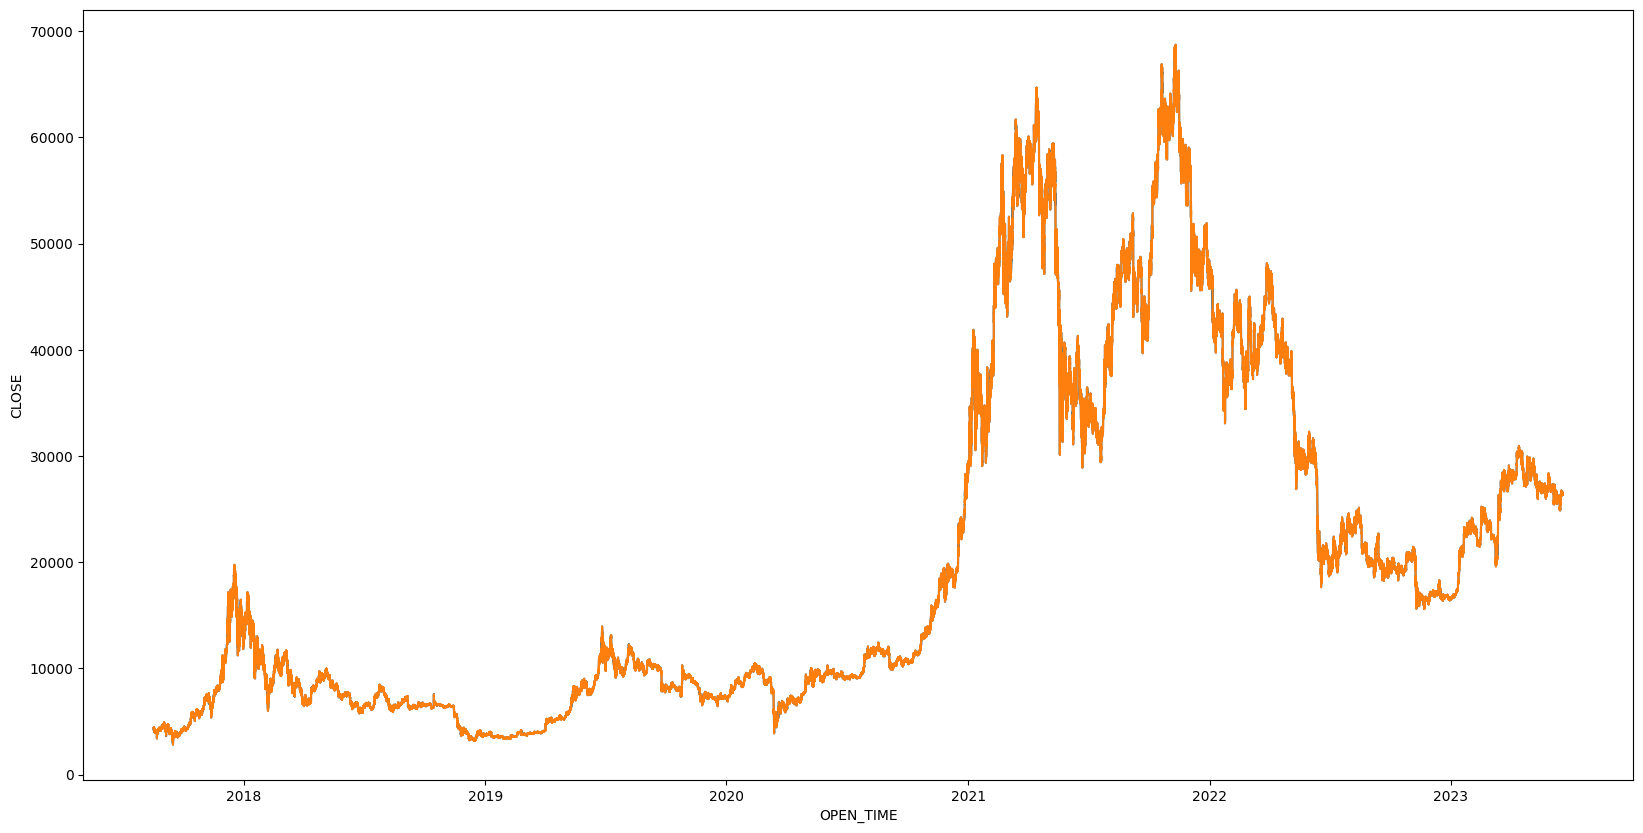

In [14]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=full_data['CLOSE'])
sns.lineplot(data=full_data['OPEN'])
plt.show()

<Axes: xlabel='OPEN_TIME', ylabel='V'>

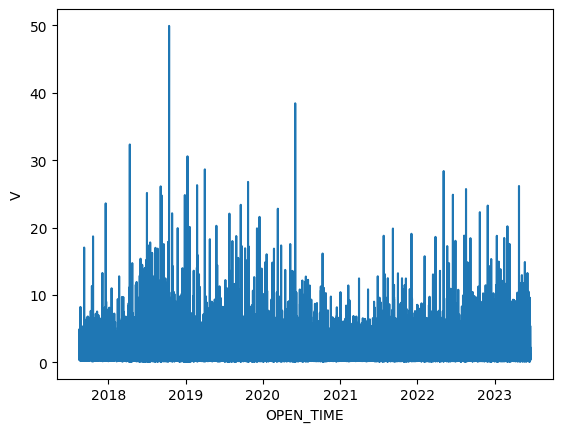

In [18]:
sns.lineplot(data=full_data['V'])

In [15]:
full_data.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,YEAR_AND_MONTH,LABEL,RETURN_RATE,V,P_BM
OPEN_TIME,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,9333.620962,9,0.489061,2089.104962,201708,NaN,0.011625,NaN,0.015996
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000,201708,NaN,0.013692,NaN,0.012864
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000,201708,NaN,0.019704,NaN,0.016304
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,2065.447829,9,0.085455,364.218136,201708,NaN,0.019704,NaN,0.015333
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570,9931.161124,11,1.546491,6595.688039,201708,NaN,0.014961,NaN,0.009833


In [5]:
full_data['V']

OPEN_TIME
2017-08-17 04:00:00         NaN
2017-08-17 04:05:00         NaN
2017-08-17 04:10:00         NaN
2017-08-17 04:15:00         NaN
2017-08-17 04:20:00         NaN
                         ...   
2023-06-19 10:40:00    0.920958
2023-06-19 10:45:00    0.920958
2023-06-19 10:50:00    0.920958
2023-06-19 10:55:00    0.920958
2023-06-19 11:00:00    0.920958
Name: V, Length: 612386, dtype: float64

In [6]:
y = full_data['CLOSE'] / full_data['OPEN'] -1

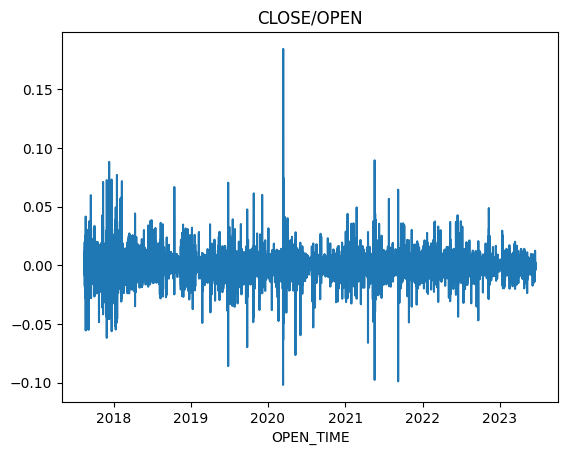

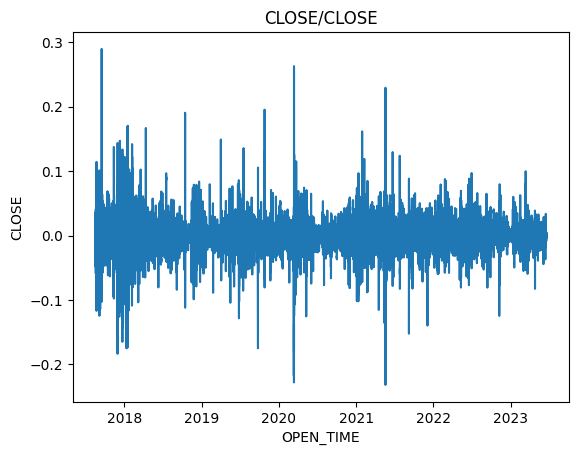

In [10]:
sns.lineplot(data=y)
plt.title('CLOSE/OPEN')
plt.show()
sns.lineplot(data=x)
plt.title('CLOSE/CLOSE')
plt.show()

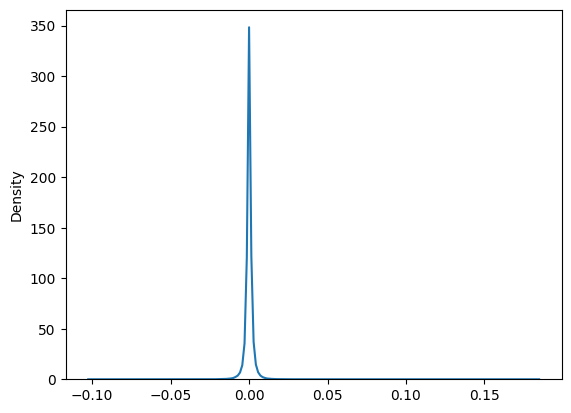

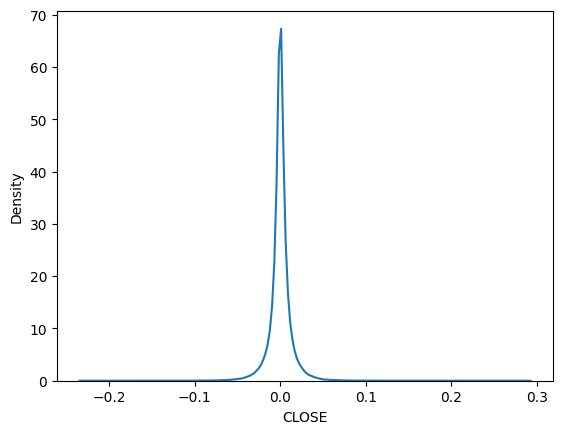

In [9]:
sns.kdeplot(data=y)
plt.show()
sns.kdeplot(data=x)
plt.show()

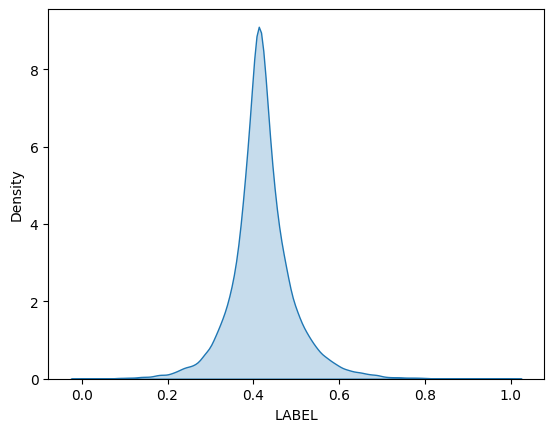

In [16]:
sns.kdeplot(data=labeled_data['LABEL'],fill=True)
# sns.kdeplot(y_for_label,fill=True)
# plt.legend(['LABEL', 'RETURN_RATE'])
# plt.xlim(-1, 1)
plt.show()

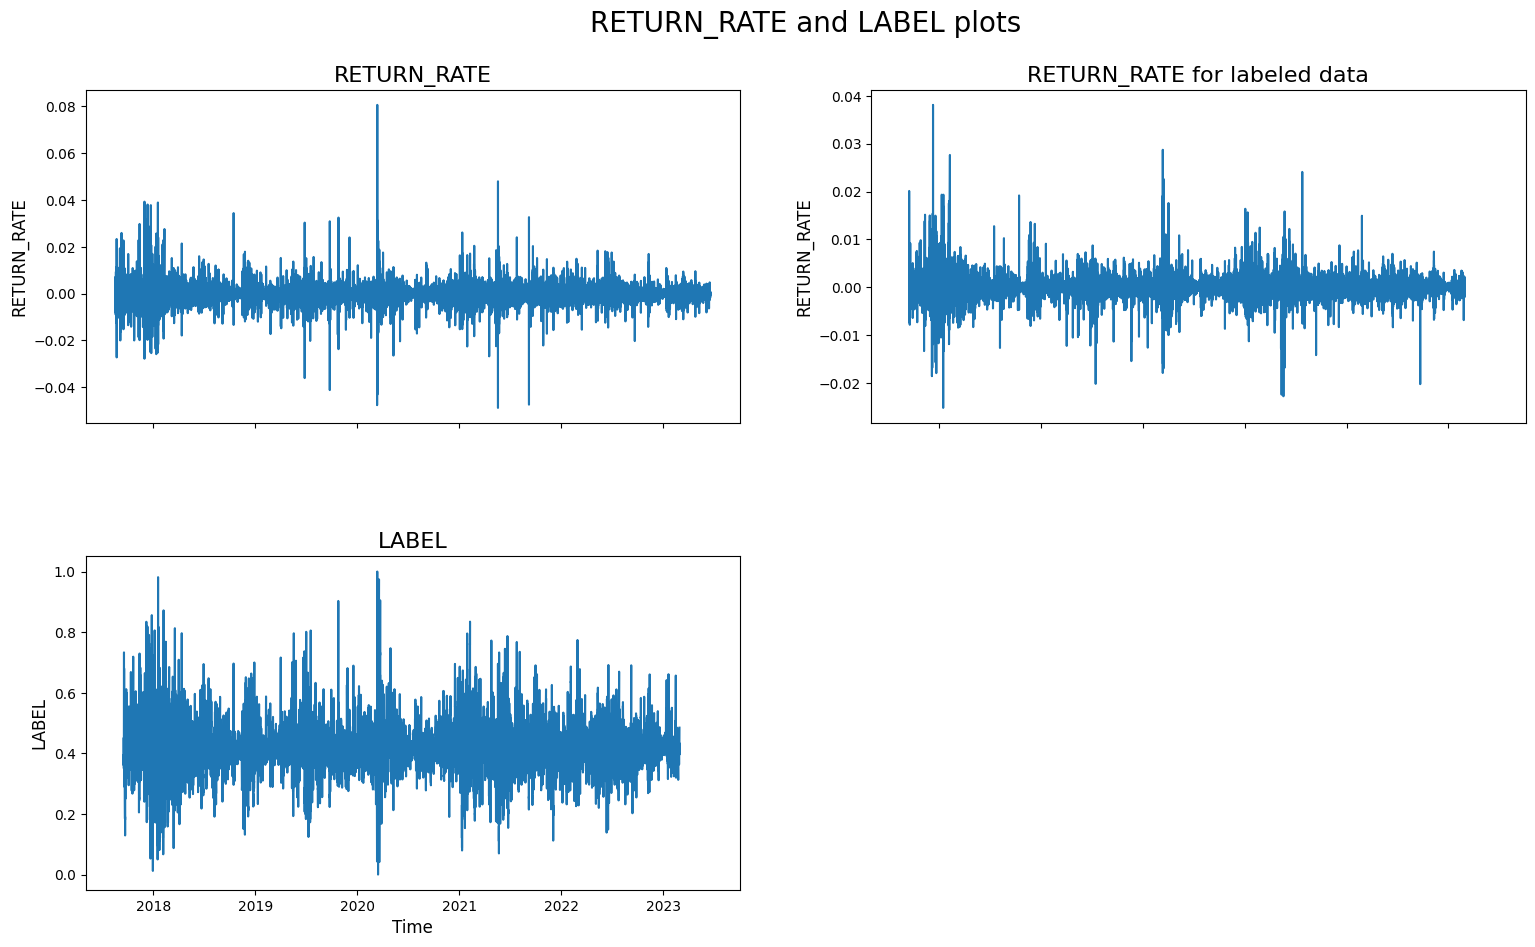

In [10]:
y = full_data['RETURN_RATE'] / np.sqrt(full_data['V']) / 2
y_for_label = y.loc[labeled_data.index]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
fig.suptitle('RETURN_RATE and LABEL plots', fontsize=20)

sns.lineplot(ax=axs[0, 0], data=y)
axs[0, 0].set_title('RETURN_RATE', fontsize=16)
axs[0, 0].set_xlabel('Time', fontsize=12)
axs[0, 0].set_ylabel('RETURN_RATE', fontsize=12)

sns.lineplot(ax=axs[0, 1], data=y_for_label)
axs[0, 1].set_title('RETURN_RATE for labeled data', fontsize=16)
axs[0, 1].set_xlabel('Time', fontsize=12)
axs[0, 1].set_ylabel('RETURN_RATE', fontsize=12)

sns.lineplot(ax=axs[1, 0], data=labeled_data['LABEL'])
axs[1, 0].set_title('LABEL', fontsize=16)
axs[1, 0].set_xlabel('Time', fontsize=12)
axs[1, 0].set_ylabel('LABEL', fontsize=12)

axs[1, 1].axis('off')

plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.2, hspace=0.4)
plt.show()


In [89]:
full_data

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,YEAR_AND_MONTH,LABEL,RETURN_RATE,V,P_BM
OPEN_TIME,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,9.333621e+03,9,0.489061,2.089105e+03,201708,NaN,0.011625,NaN,0.010271
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,201708,NaN,0.013692,NaN,0.010484
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000e+00,201708,NaN,0.019704,NaN,0.011344
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,2.065448e+03,9,0.085455,3.642181e+02,201708,NaN,0.019704,NaN,0.011546
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570,9.931161e+03,11,1.546491,6.595688e+03,201708,NaN,0.014961,NaN,0.010063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 10:40:00,26398.05,26400.00,26390.00,26398.00,53.635990,1.415872e+06,1450,23.608760,6.232054e+05,202306,0.484824,-0.001239,0.920958,0.013287
2023-06-19 10:45:00,26398.00,26399.97,26396.01,26396.89,42.078480,1.110761e+06,1245,20.234130,5.341305e+05,202306,0.484824,-0.001239,0.920958,0.009175
2023-06-19 10:50:00,26396.90,26396.90,26383.05,26392.77,86.849990,2.292146e+06,1605,29.394780,7.757901e+05,202306,0.484824,-0.001239,0.920958,0.011974


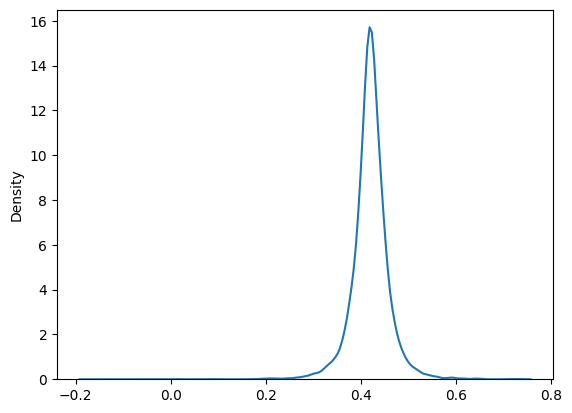

In [93]:
t = pd.date_range(start='2021-12-31', end='2023-03-03', freq='H')
public_test_train = full_data.resample('H').last().loc[t]
public_test_train
ans = public_test_train['RETURN_RATE'] / (2* np.sqrt(public_test_train['V']*public_test_train['P_BM'])) + 0.42
sns.kdeplot(data=ans)
idx = t.astype(np.int64) // 10**6
public_test= pd.DataFrame({'OPEN_TIME':idx, 'PREDICTION':ans})
public_test.to_csv('C:/Users/nguye/Downloads/public_test_test.csv', index=False)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=10)

# model = RandomForestRegressor(n_estimators=120, random_state=10,verbose=0,max_depth=12)

# model.fit(X_train, y_train)





In [16]:
# # public_test_pred = p_1_3['RETURN_RATE'] / np.sqrt(full_data['V']) / 2
# p_1_3['P_BM'] = test1
# public_test_pred = p_1_3['RETURN_RATE'] / np.sqrt(p_1_3['V']*p_1_3['P_BM']) / 2
# public_test_pred

In [18]:
labeled_data['LABEL'].describe()

count    47662.000000
mean         0.420557
std          0.074462
min          0.000000
25%          0.385336
50%          0.416168
75%          0.451782
max          1.000000
Name: LABEL, dtype: float64

# Trainning data

In [89]:
X = full_data.loc[labeled_data.index[(labeled_data.index>='2020-01-01') & (labeled_data.index<'2022-08-01')]]
y = X['LABEL']
X.drop(columns=['YEAR_AND_MONTH','LABEL','OPEN','CLOSE','QUOTE_ASSET_VOLUME','TAKER_BUY_BASE_ASSET_VOLUME','TAKER_BUY_QUOTE_ASSET_VOLUME'], inplace=True)
X

,HIGH,LOW,VOLUME,NUMBER_OF_TRADES,RETURN_RATE,V
OPEN_TIME,,,,,,
2020-01-01 00:00:00,7196.25,7178.64,95.509133,1127,-0.002149,1.398784
2020-01-01 01:00:00,7185.86,7175.71,30.163076,596,0.000950,1.445942
2020-01-01 02:00:00,7223.37,7214.09,62.727497,809,0.000240,0.930241
2020-01-01 03:00:00,7245.00,7230.25,87.259123,879,-0.001012,0.767176
2020-01-01 04:00:00,7229.72,7223.93,64.682238,951,0.000496,1.006652
...,...,...,...,...,...,...
2022-07-31 19:00:00,23909.02,23700.37,1119.221810,28292,0.006447,0.989036
2022-07-31 20:00:00,23892.43,23833.68,518.972810,16017,0.001233,0.312448
2022-07-31 21:00:00,23827.25,23795.05,251.615420,9515,0.000211,0.966001


In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)
model = RandomForestRegressor(n_estimators=140, random_state=12,verbose=1,max_depth=15,min_samples_leaf=3)
# model.fit(X_train, y_train)

In [91]:
model.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   38.1s finished


RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=140,
                      random_state=12, verbose=1)

# Predict

In [104]:
# Create a dataframe and resample to hourly data
t = pd.date_range(start='2021-12-31', end='2023-03-03', freq='H')
public_test_train = full_data.resample('H').last().loc[t]

# Drop the columns that are not needed
public_test_train.drop(columns=['YEAR_AND_MONTH','LABEL','OPEN','CLOSE','QUOTE_ASSET_VOLUME','TAKER_BUY_BASE_ASSET_VOLUME','TAKER_BUY_QUOTE_ASSET_VOLUME'], inplace=True)
# Fill the missing values
public_test_train.fillna(method='bfill', inplace=True)

# index OPENTIME 
idx = t.astype(np.int64) // 10**6

In [93]:
public_test_pred = model.predict(public_test_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.1s finished


In [94]:
public_test= pd.DataFrame({'OPEN_TIME':idx, 'PREDICTION':public_test_pred})
public_test.to_csv('C:/Users/nguye/Downloads/public_test1.csv', index=False)

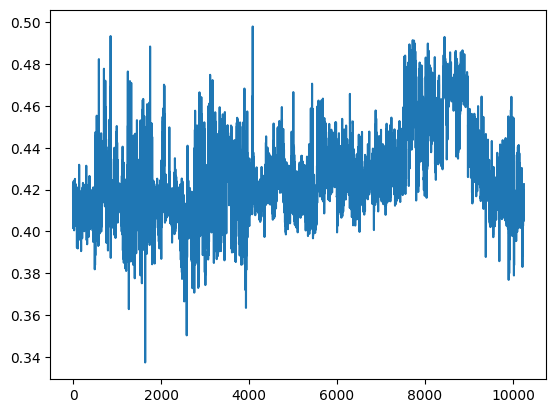

<Axes: ylabel='Density'>

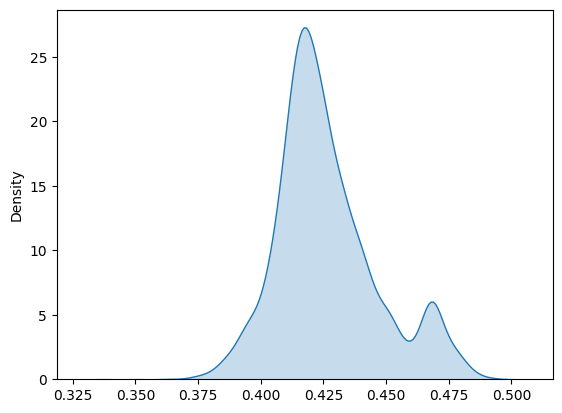

In [95]:
sns.lineplot(data=public_test_pred)
plt.show()
sns.kdeplot(data=public_test_pred,fill=True)

In [101]:
public_test_pred

array([0.4215457 , 0.40152832, 0.40873509, ..., 0.41551208, 0.41321331,
       0.42259282])

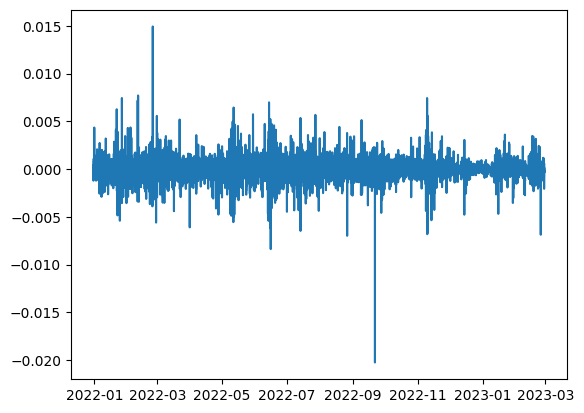

<Axes: ylabel='LABEL'>

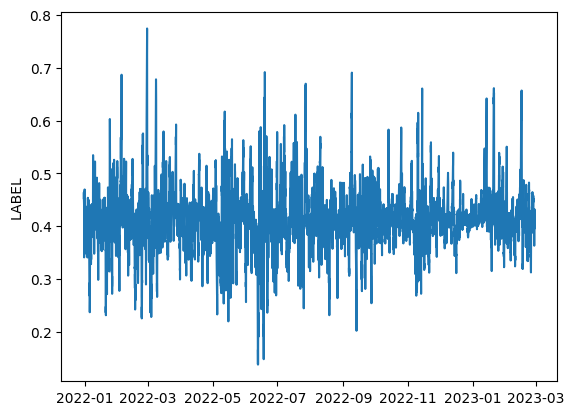

In [108]:
t1 = pd.date_range(start='2021-12-31', end='2023-02-28', freq='H')
# sns.kdeplot(data=labeled_data['LABEL'].loc[t1])
sns.lineplot(data=y_for_label.loc[t1])
plt.show()
sns.lineplot(data=labeled_data['LABEL'].loc[t1])

In [97]:
labels
# Tính từ đầu 2020 đến tháng 7 năm 2022

,LABEL
OPEN_TIME,
2017-09-16 10:00:00,0.393885
2017-09-16 11:00:00,0.390215
2017-09-16 12:00:00,0.360434
2017-09-16 13:00:00,0.398650
2017-09-16 14:00:00,0.451718
...,...
2023-02-28 19:00:00,0.448246
2023-02-28 20:00:00,0.470401
2023-02-28 21:00:00,0.468764


In [98]:
# from joblib import dump, load
# dump(model, 'model_nestquant_v1.joblib')

In [99]:
# loaded_model = load('model_nestquant_v1.joblib')


In [49]:
from shutil import move, copy
import os
from pathlib import Path
# match any img
# x = Path.glob(Path('C:/Users/nguye/Downloads/'), '*.png')
# os.mkdir('C:/Users/nguye/Downloads/ExcelFiles')
# for i in x:
#     # move to a non-existing folder
#     copy(i, 'C:/Users/nguye/Downloads/ExcelFiles')
# # create a new folder
# list(x)

# find any image file with .png, .jpg, .jpeg extension
x = Path.glob(Path('C:/Users/nguye/Downloads/'), '*.*')
for i in x:
    print(i) if i.suffix in ['.pdf'] else None

C:\Users\nguye\Downloads\0. Quy trinh thuc tap doanh nghiep - Truong CNTT&TT.pdf
C:\Users\nguye\Downloads\Abraham Silberschatz-Operating System Concepts (9th,2012.12).pdf
C:\Users\nguye\Downloads\Academic CV.pdf
C:\Users\nguye\Downloads\BI KIP TU HOC IELTS TU 0 LEN 8.0_NGOC BACH.pdf
C:\Users\nguye\Downloads\Bài thi Tìm hiểu về Pháp luật kỳ 20222 [BĐ 25.06.2023]v.pdf
C:\Users\nguye\Downloads\Bài tập lớn Kỳ 20222.pdf
C:\Users\nguye\Downloads\chuyen-de-hon-so-so-thap-phan-phan-tram-toan-lop-6.pdf
C:\Users\nguye\Downloads\de-cuong-on-tap-so-hoc-chuong-2-toan-lop-6.pdf
C:\Users\nguye\Downloads\Deadlock (12).pdf
C:\Users\nguye\Downloads\Deadlock_Report_ 20215343.pdf
C:\Users\nguye\Downloads\Deadlock__Report_.pdf
C:\Users\nguye\Downloads\draft.pdf
C:\Users\nguye\Downloads\giaybaoduthi.pdf
C:\Users\nguye\Downloads\Giải Chi Tiết TOEIC của CFL Test 01.pdf
C:\Users\nguye\Downloads\Giải Chi Tiết TOEIC của CFL Test 02.pdf
C:\Users\nguye\Downloads\IT3070-Five.pdf
C:\Users\nguye\Downloads\IT3070-Four